In [1]:
#!pip install control

In [2]:
from scipy.io import loadmat
import numpy as np
from numpy import *
from scipy.integrate import odeint
import scipy as sp
import matplotlib.pyplot as plt
import pickle
from control import lqr, ss, ctrb, obsv
from control.matlab import lsim
import itertools
from tqdm import tqdm

# **The cart and pole system**

Consider the cart-and-pole system here depicted:
<div>
<img src="https://drive.google.com/uc?export=view&id=1Yu5zZ57OEEYZ678yWLaU7h-Wq3M9vV9E" width="200">
</div>
whose dynamics follows the following equations:

\begin{align}
  \ddot{\theta}&=\frac{g \sin(\theta)\,+\,\cos(\theta) \left[ \frac{-F\,-\,m_p\,l\,\dot{\theta}^2 \sin \left(\theta\right)}{m_c\,+\,m_p}\right]-\frac{\mu_p\dot{\theta}}{m_p\,l}}{l\,\left[\frac{4}{3}-\frac{m_p\,cos^2\left(\theta\right)}{m_c\,+\,m_p}\right]}
\end{align}
>>>>>>>>>>>>>>>>>>>>>>>>$(*)$

\begin{align}
  \ddot{p}_c&=\frac{F\,+\,m_p\,l\,\left[\dot{\theta}^2\,\sin\left(\theta\right)\,-\,\ddot{\theta}\,\cos(\theta)\right]}{m_c\,+\,m_p}
\end{align}

where $g = 9.8\,\text{m/sec}$ is the gravitational acceleration, $m_c = 1\,\text{kg}$ is the cart mass, $m_p = 0.1\,\text{kg}$ is the pole mass, $l = 0.5\,\text{m}$ is the half-pole length, $\mu_p = 0.000002$ is the pole on cart friction coefficient, and $F:|F|\leq 10\,\text{N}$ is the force applied to cart's center of mass.

# 1. Clearly define an optimal control problem for pole balancing

Pole balancing is a classic problem in control theory where the goal is to maintain the balance of an inverted pendulum (pole) on a moving platform. The optimal control problem for pole balancing involves finding a control policy that minimizes a cost function while ensuring the stability of the system. Here's a more detailed formulation:

**System dynamics**

Consider a simple inverted pendulum system with a cart that can move horizontally. The state of the system is described by the position of the cart ($p_c$) and the angle of the pole $\theta$). The dynamics of the system can be modeled using differential equations, such as the nonlinear equations of motion for an inverted pendulum.

**Objective**

Define a cost function that captures the performance and stability of the system. The objective is to find a control policy that minimizes this cost function over a specified time horizon.


The optimal control problem can be formulated as finding the control input $u(t)$ that minimizes the cost function while satisfying the system dynamics and any constraints:

$min_{⁡u(t)}J(x(t),\theta(t),u(t))$

subject to the dynamics of the system and any imposed constraints.

Solving this optimal control problem will yield a control policy that stabilizes the inverted pendulum while satisfying the specified performance criteria.

# 2. Is the LQR applicable in its simple form on the system? If not what is missed?




LQR can be applied on the pole balancing problem, but only if I can linearize the system.

Once I have linearized the system I will have to:
- determine good $Q$ and $R$ values
- convert the system from continuous-time to discrete-time
- calculate the $K$ constant using discrete-time algebraic Riccati's equation

# 3. Design an LQR for the linearized version of the cart and pole obtained in the previous hands-on. Justify all the design choices and perform all the required checks



Load the matrices for the continuous-time system

In [3]:
with open('linearized_model.pkl', 'rb') as file: 
    linearized_model = pickle.load(file) 

In [4]:
theta2p_linA = linearized_model["theta2p_linA"]
x2p_linA = linearized_model["x2p_linA"]

A_c = np.array([
    [0, 1, 0, 0],
    theta2p_linA,
    [0, 0, 0, 1],
    x2p_linA
])
B_c = np.array([
    [0],
    [linearized_model["theta2p_linB"]],
    [0],
    [linearized_model["x2p_linB"]]
])
C_c = np.eye(4)
D_c = 0

A_c, B_c

(array([[0, 1, 0, 0],
        [15.7756097560976, -6.43902439024390e-5, 0, 0],
        [0, 0, 0, 1],
        [-0.717073170731708, 2.92682926829268e-6, 0, 0]], dtype=object),
 array([[0],
        [-1.46341463414634],
        [0],
        [0.975609756097561]], dtype=object))

I have to convert the matrices into discrete form, since the LQR will make use of the discrete Riccati equation.

In [5]:
sampling_time = 0.02

A, B, C, D, _ =  sp.signal.cont2discrete((A_c, B_c, C_c, D_c), dt=sampling_time)

Checking for reachability and controllability is important in the context of LQR control because LQR assumes that the system is fully controllable. If the system is not controllable or reachable, the optimal control design may not be achievable or may not lead to desirable performance.

Those assumptions must be satisfied because, in order to control a system:
- it must be able to reach any state starting from any other state (reachability) 
- the inputs to the system must let it reach any state (controllability).

To do so I have to build the controllability and observability matrices and check their rank to be maximum (in this case 4).

In [6]:
ctrb_matrix = ctrb(A, B)
print(np.linalg.matrix_rank(ctrb_matrix))
obsv_matrix = obsv(A, C)
print(np.linalg.matrix_rank(obsv_matrix))

4
4


The check is passed, so I can step into the definition of the LQR.

In [7]:
Q = np.diag([1, 0, 1, 0]) # angle penalty, position penalty
R = 1 # actuator force penalty

P = sp.linalg.solve_discrete_are(A, B, Q, R)

K = (np.linalg.inv(R + (B.T @ P @ B))) @ B.T @ P @ A
K

array([[-28.67493912,  -7.28831156,  -0.91119427,  -1.82420047]])

In the last point of this hands on, I will execute a simulation to try to find (using grid search) the best values for Q and R that will satisfy the system's requirements.

# 4.    Simulate the linearized cart and pole system controlled by an LQR. Plot the significant behaviors

In [8]:
g = 9.8 # gravitational acceleration
mc = 1  # cart mass [kg]
l = 0.5 # half-pole length [m]
m = 0.1 # pole mass [kg]
miup = 2e-6 # pole friction coefficient

B = B.flatten()

The following function will work on the discrete-time simulation, so it's making use of the matrices `A` and `B`. If I were to use `A_c` and `B_c`, I'd also have to use `odeint` thus making all the computations much more expensive.

In [9]:
def cart_and_pole_lin(x, F):
    dxdt = A @ x + B * F
    return dxdt.astype("float64")

In [10]:
X0 = [np.pi/4, 0, 0, 0]

In [11]:
x0_odeint = np.array(X0)

X_history_l = [x0_odeint]
t0_odeint = 0
time_step = 0.02
time_sim = np.arange(0.0, 20, time_step)
uvec = np.zeros_like(time_sim)

for i in range(len(uvec) - 1):
    uvec[i] = -K @ x0_odeint # set the input
    F = uvec[i]

    x0_odeint = cart_and_pole_lin(x0_odeint, F)
    
    X_history_l = np.append(X_history_l, [x0_odeint], axis=0)

/tmp/ipykernel_4613/825256718.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  uvec[i] = -K @ x0_odeint # set the input


Text(0.5, 1.0, 'theta(t)')

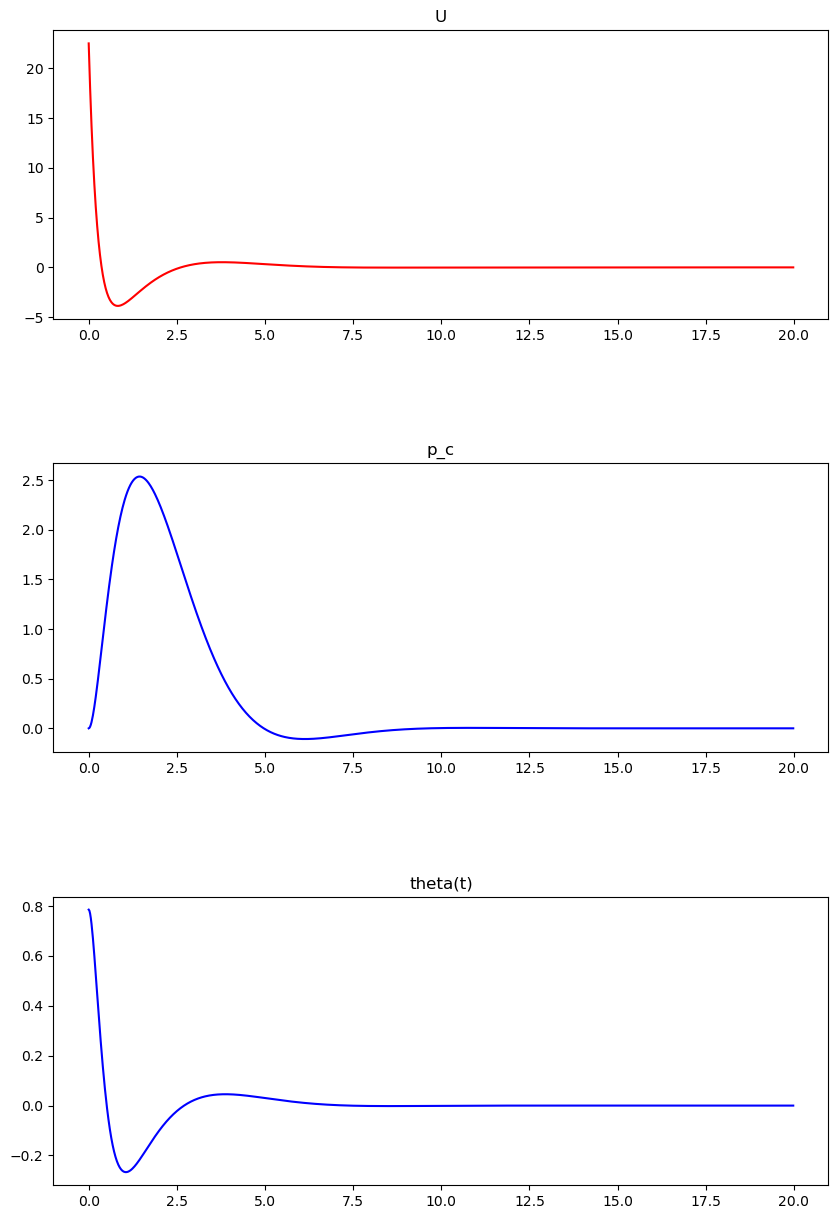

In [12]:
plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(3)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(time_sim, uvec, 'r')
axs[0].set_title("U")

axs[1].plot(time_sim, X_history_l[:,2], 'b')
axs[1].set_title("p_c")

axs[2].plot(time_sim, X_history_l[:,0], 'b')
axs[2].set_title("theta(t)")

The performance of the system is good, but I'm not satisfying the requirements (the input force is $\geq 10N$).

# 5.  Simulate the non-linear cart and pole system controlled by the previously obtained LQR. Plot the significant behaviors



In [13]:
def cart_and_pole_odeint(x, t, F):
    dxdt = np.zeros_like(x)

    dxdt[0] = x[1] #thetap
    dxdt[1] = (g*sin(x[0])+ cos(x[0])*((-F-m*l*(x[1]**2)*sin(x[0]))/(mc+m))-((miup*x[1])/(m*l))) / (l*((4/3)-((m*(cos(x[0])**2))/(mc+m))))    #theta2p
    dxdt[2] = x[3] #xp
    dxdt[3] = (F+m*l*((x[1]**2)*sin(x[0])-dxdt[1]*cos(x[0])))/(mc+m) #x2p
    return dxdt

In [14]:
x0_odeint = np.array(X0)

X_history = [x0_odeint]
t0_odeint = 0
time_step = 0.02
t1_odeint = t0_odeint+time_step
t_odeint = np.array([t0_odeint, t1_odeint])
time_sim = np.arange(0.0, 20, time_step)
uvec2 = np.zeros_like(time_sim)

for i in range(len(uvec) - 1):
    uvec2[i] = -(K @ x0_odeint[np.newaxis].T)[0][0] + uvec[i] # -K(x - x_hat) + (u - u_hat), but x_hat = u_hat = 0, so they can be omitted
    F = uvec2[i]
    
    x_odeint = odeint(cart_and_pole_odeint, x0_odeint, t_odeint, args=(F, ))
    x0_odeint = x_odeint[1]
    X_history=np.append(X_history, [x0_odeint], axis= 0)

Text(0.5, 1.0, 'theta(t)')

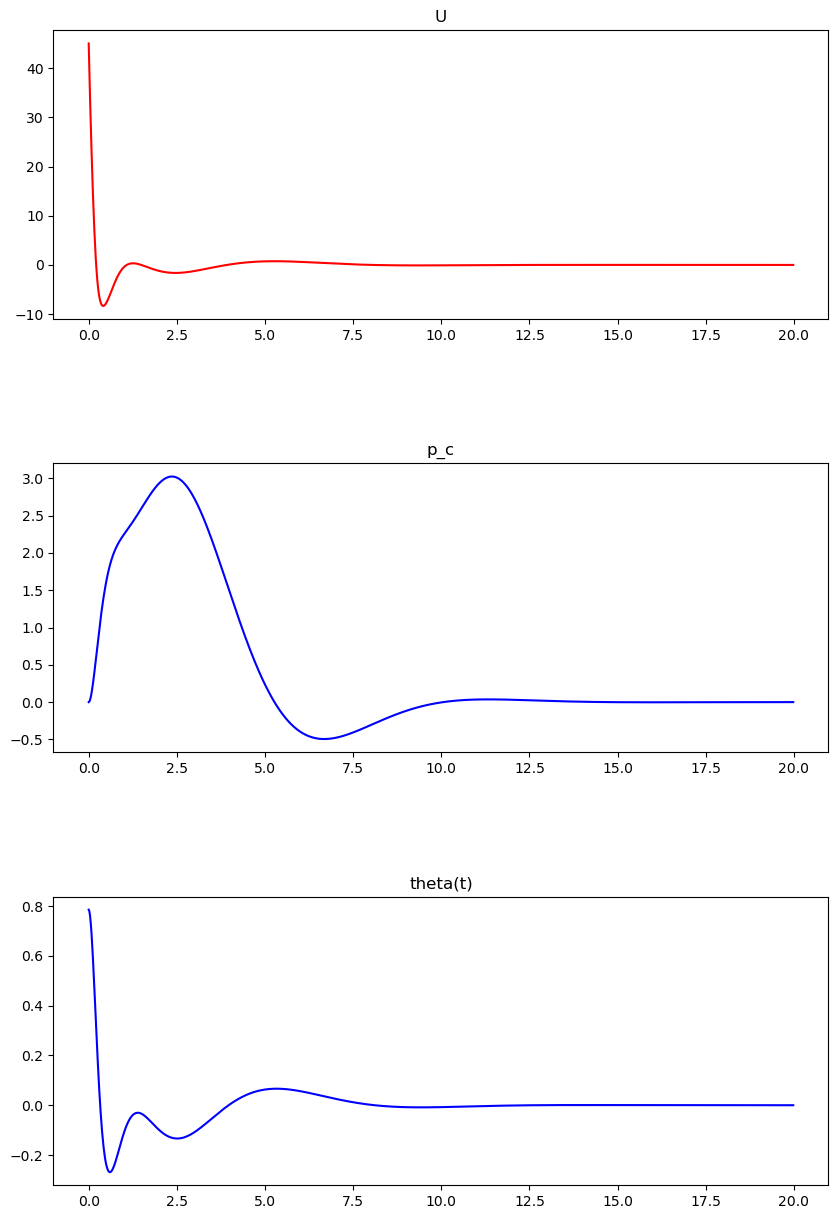

In [15]:
plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(3)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(time_sim, uvec2, 'r')
axs[0].set_title("U")

axs[1].plot(time_sim, X_history[:,2], 'b')
axs[1].set_title("p_c")

axs[2].plot(time_sim, X_history[:,0], 'b')
axs[2].set_title("theta(t)")

# 6. Comment results obtained in the two simulations

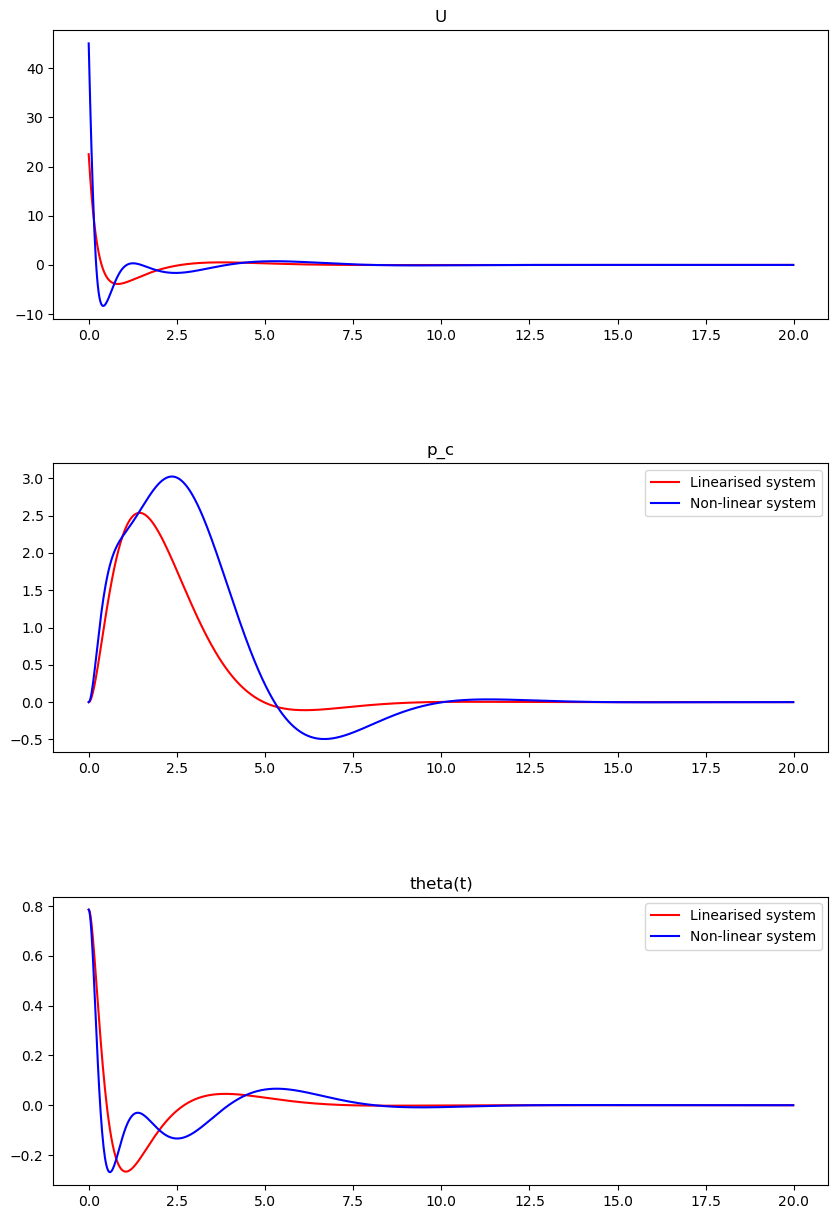

In [19]:
plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(3)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(time_sim, uvec, 'r')
axs[0].plot(time_sim, uvec2, 'b')
axs[0].set_title("U")

axs[1].plot(time_sim, X_history_l[:,2], 'r')
axs[1].plot(time_sim, X_history[:,2], 'b')
axs[1].set_title("p_c")
axs[1].legend(["Linearised system", "Non-linear system"])


axs[2].plot(time_sim, X_history_l[:,0], 'r')
axs[2].plot(time_sim, X_history[:,0], 'b')
axs[2].set_title("theta(t)")
axs[2].legend(["Linearised system", "Non-linear system"])


In [17]:
max(uvec)

22.52124452352878

As with any linearized system dynamics, this approximation works best as the system is close to $(0,0,0,0)$. This can be noted from the last charts, where see maximal divergence between the two curves can be seen in the first swings. As the system is converging towards the equilibrium pont, those differences aren't visible anymore.

The biggest problem is that using an LQR was not possible to meet all the requirements, in particular the maximum force has been exceeded. I tried tweaking $Q$ and $R$, but the result would be that less force (still more than $10N$) is going to be applied and the $p_c$ constraint will not be satisfied anymore.

In [20]:
def simulate_Q_R(Q, R):
    A, B, C, D, _ =  sp.signal.cont2discrete((A_c, B_c, C_c, D_c), dt=sampling_time)

    P = sp.linalg.solve_discrete_are(A, B, Q, R)

    K = (np.linalg.inv(R + (B.T @ P @ B))) @ B.T @ P @ A

    B = B.flatten()
    
    x0_odeint = np.array(X0)

    X_history_l = [x0_odeint]
    time_step = 0.02
    time_sim = np.arange(0.0, 20, time_step)
    uvec = np.zeros_like(time_sim)

    for i in range(len(uvec) - 1):
        uvec2[i] = -(K @ x0_odeint[np.newaxis].T)[0][0] + uvec[i] # set the input
        F = uvec2[i]

        x0_odeint = cart_and_pole_lin(x0_odeint, F)
        
        X_history_l = np.append(X_history_l, [x0_odeint], axis=0)
    
    # Check for requirements
    return [
        max(abs(uvec2)) <= 10, # actuator force
        max(abs(X_history_l[:,2])) <= 5 # position
    ]
    

Q_list = [] # angle penalty, position penalty
R_list = [] # actuator force penalty

for i in range(-6, 7):
    Q_list.append(np.diag([1, 0, 10 ** i, 0]))
for i in range(-6, 7):
    Q_list.append(np.diag([10 ** i, 0, 1, 0]))

for i in range(-6, 7):
    R_list.append(10 ** i)

# All possible combinations of Q and R:
for Q, R in tqdm(list(itertools.product(Q_list, R_list))):
    sim_res = simulate_Q_R(Q, R)
    if all(sim_res): # To check if just one of the requirements was satisfied use:
    # if True in sim_res:
        print("Q", Q, "R", R)

100%|██████████| 338/338 [00:02<00:00, 121.41it/s]


Some choices that can lead to only one of the two requirements satisfied, but I was not able to satisfy both of them. Because of this, I chose to assign the same factor (1) to each penalty (angle, position and actuator force).
All the other combinations I tested are more or less equivalent, since they don't satisfy all the project's requirements.